<a href="https://colab.research.google.com/github/minjoo1412/2020_AI/blob/master/%EA%B3%BC%EC%A0%9C3%EC%A0%95%EB%8B%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1번 [영상 인식] 다음 코드를 무엇을 의미하는지 이해하고 실행하여 결과를 확인하세요. (10점)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

#GPU의 사용여부 가능 여부 확인 --> GPU를 쓸수 있다면 is_cuda가 True로 바뀜
in_cuda = False
if torch.cuda.is_available():
  is_cuda = True

transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST('data/', train=True, transform=transformation, download=True)
test_dataset = datasets.MNIST('data/', train=False, transform=transformation, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

sample_data = next(iter(train_loader))

def plot_img(image):
  image = image.numpy()[0]
  mean = 0.1307
  std = 0.3081
  image = ((mean * image) + std)
  plt.imshow(image, cmap='gray')

## (1) 화면 출력 확인



*   `plot_img`함수에 이미지를 받으면 해당 이미지의 0번째 배열을 가져와서 정규분포화 한 후에 그림을 보여주게 설정한다



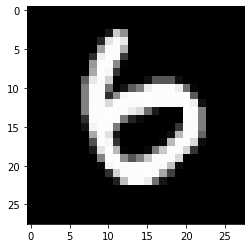

In [ ]:
plot_img(sample_data[0][2])

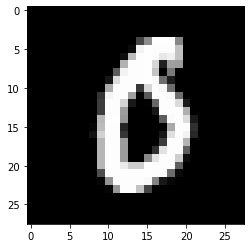

In [ ]:
plot_img(sample_data[0][1])

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20,kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    #x = F.dropout(x, p=0.1, training=self.training)
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

model = Net()

#GPU를 사용할 수 있다면 모델을 GPU를 사용하여 실행함
if is_cuda:
  model.cuda()

optimizer = optim.SGD(model.parameters(), lr=0.01)
data, target = next(iter(train_loader))

output = model(Variable(data.cuda()))

## (2) `output.size()`, `target.size()` 출력 확인

- `output`과 `target`의 사이즈를 비교해보면 `target`은 정답인 1개의 값을 표현하기 때문에 sample의 개수와 동일한 크기의 [32]만 출력된다. 즉, 32개의 샘플에 대한 정답값만을 표현한다. 반면 `output`은 각 10개의 숫자에 대한 확률값이 출력되기 때문에 [32,10]으로 사이즈가 표현된다. 즉, 32개의 샘플에 대한 0~9까지의 숫자의 각각에 대한 확률값을 표현한다.

In [ ]:
print(output.size())
print(target.size())

torch.Size([32, 10])
torch.Size([32])


## (3) 화면 출력 확인

- 학습이 잘 이루어지는 것을 확인

In [ ]:
def fit(epoch, model, data_loader, phase='training', volatile=False):
  if phase == 'training':
    model.train()
  if phase == 'validation':
    model.eval()
    volatile=True
  running_loss = 0.0
  running_correct = 0
  for batch_idx, (data, target) in enumerate(data_loader):
    if is_cuda:
      data, target = data.cuda(), target.cuda()
    data, target = Variable(data, volatile), Variable(target)
    if phase == 'training':
      optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)

    running_loss += F.nll_loss(output, target, size_average=False).data
    preds = output.data.max(dim=1, keepdim=True)[1]
    running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
    if phase == 'training':
      loss.backward()
      optimizer.step()

  loss = running_loss / len(data_loader.dataset)
  accuracy = 100. * running_correct / len(data_loader.dataset)

  print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuaracy is {running_correct}/{len(data_loader.dataset)}{accuracy: {10}.{4}}')
  return loss, accuracy

train_losses, train_accuracy = [], []
val_losses, val_accuracy = [], []
for epoch in range(1, 20):
  epoch_loss, epoch_accuracy = fit(epoch, model, train_loader, phase='training')
  val_epoch_loss, val_epoch_accuracy = fit(epoch, model, test_loader, phase='validation')
  train_losses.append(epoch_loss)
  train_accuracy.append(epoch_accuracy)
  val_losses.append(val_epoch_loss)
  val_accuracy.append(val_epoch_accuracy)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is  0.59 and training accuaracy is 49140/60000      81.9
validation loss is  0.17 and validation accuaracy is 9453/10000     94.53
training loss is  0.22 and training accuaracy is 56248/60000     93.75
validation loss is 0.099 and validation accuaracy is 9690/10000      96.9
training loss is  0.16 and training accuaracy is 57158/60000     95.26
validation loss is 0.075 and validation accuaracy is 9759/10000     97.59
training loss is  0.13 and training accuaracy is 57571/60000     95.95
validation loss is 0.067 and validation accuaracy is 9780/10000      97.8
training loss is  0.12 and training accuaracy is 57906/60000     96.51
validation loss is 0.055 and validation accuaracy is 9812/10000     98.12
training loss is  0.11 and training accuaracy is 58109/60000     96.85
validation loss is  0.05 and validation accuaracy is 9830/10000      98.3
training loss is 0.097 and training accuaracy is 58300/60000     97.17
validation loss is  0.05 and validation accuaracy is 9841/1

## (4) 화면 출력 확인
- `training loss`와 `validation loss` 모두 잘 줄어드는 것을 확인할 수 있음

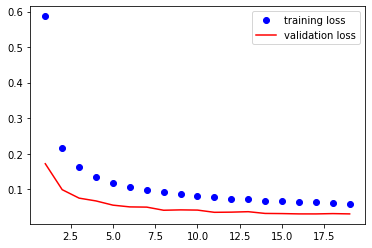

In [ ]:
plt.plot(range(1, len(train_losses) + 1), train_losses, 'bo', label='training loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, 'r', label='validation loss')
plt.legend()

## (5) 화면 출력 확인

- `train accuracy`와 `val accuracy` 모두 점차 올라가는 것을 확인할 수 있음

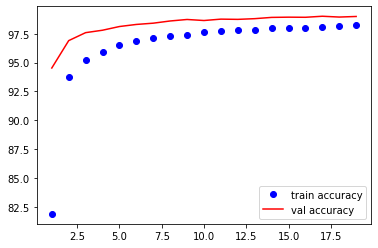

In [ ]:
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, 'bo', label='train accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, 'r', label='val accuracy')
plt.legend()

# 2. [CNN] 다음 코드를 무엇을 의미하는지 이해하고 실행하여 결과를 확인하세요. (10점)

## (1) 정의된 컨볼루션 신경망의 구조 설명

* 총 2개의 conv layer와 3개의 fully connected layer로 구성
* conv layer 이후 activation function으로는 ReLU를 사용하고,그 후 maxpooling을 (2,2) kernel size로, conv - ReLU - pool 순서로 수행

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    #1 input image channel, 6 output channels, 5*5 square conv. kernel
    self.conv1 = nn.Conv2d(1, 6, 5)
    self.conv2 = nn.Conv2d(6, 16, 5)

    #an affine operation: y = Wx + b
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    #Max pooling over a (2, 2) window
    x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

  def num_flat_features(self, x):
    size = x.size()[1:]
    num_features = 1
    for s in size:
      num_features *= s
    return num_features

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## (2) 화면 출력 확인

- `net.parameters()`를 사용하여 정의된 신경망의 학습 가능한 매개변수들을 확인할 수 있음
- `params[0].size()`는 conv1의 가중치를 의미


In [ ]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 5, 5])


## (3) 화면 출력 확인

- 임의의 크기가 1 * 32 * 32의 입력값을 주었을 때의 결과 값

In [ ]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[ 0.0059,  0.0323, -0.1355,  0.0753, -0.0538,  0.0406,  0.0294,  0.0379,
          0.0111,  0.0031]], grad_fn=<AddmmBackward>)


## (4) 화면 출력 확인
- `zero_grad()` 를 사용해서 그레디언트를 초기화한 후 역전파를 진행
- `target`과 비교해서 `MSELoss`를 구한 결과

In [ ]:
net.zero_grad()
out.backward(torch.randn(1, 10))

output = net(input)
target = torch.randn(10)
target = target.view(1, -1)
criterion = nn.MSELoss()

loss = criterion(output,target)
print(loss)

tensor(0.8172, grad_fn=<MseLossBackward>)


## (5) backward 전, 후 화면 출력 확인
- 그레디언트를 0으로 초기화한 후 `backward`이전의 `bias`에 대한 그레디언트를 확인 --> 모두 0 값
- `backward()`를 진행한 후의 그레디언트 값

In [ ]:
net.zero_grad()

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias after backward
tensor([-0.0116, -0.0006, -0.0081, -0.0002,  0.0068, -0.0164])


In [ ]:
learning_rate = 0.01
for f in net.parameters():
  f.data.sub_(f.grad.data * learning_rate)

import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.01)

optimizer.zero_grad()
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()

# 3. [분류기 학습] 다음 코드를 무엇을 의미하는지 이해하고 실행하여 결과를 확인하세요. (14점)

## (1) 화면 출력 확인

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog','frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## (2) 화면 출력 확인

 ship truck   cat horse 


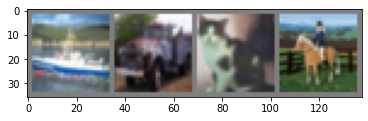

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(''.join('%5s ' % classes[labels[j]] for j in range(4)))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net()

## (3) 화면 출력 확인 및 학습이 되고 있는지 서술

- `loss`가 점차 줄어드는 것을 확인할 수 있음

In [ ]:
#3.손실함수 정의, 교차 엔트로피와 SGD + momentum
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#훈련집합을 이용하여 신경망을 학습시킴
for epoch in range(5):
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    #get the inputs
    inputs, labels = data

    #zero the parameter gradients
    optimizer.zero_grad()
    #forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    #print statistics
    running_loss += loss.item()
    if i % 1000 == 999:   #print every 1000 mini-batches
      print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 1000))
      running_loss = 0.0
print('Finished Training')

[1,  1000] loss: 2.296
[1,  2000] loss: 2.153
[1,  3000] loss: 1.941
[1,  4000] loss: 1.785
[1,  5000] loss: 1.691
[1,  6000] loss: 1.648
[1,  7000] loss: 1.599
[1,  8000] loss: 1.539
[1,  9000] loss: 1.551
[1, 10000] loss: 1.492
[1, 11000] loss: 1.468
[1, 12000] loss: 1.487
[2,  1000] loss: 1.407
[2,  2000] loss: 1.388
[2,  3000] loss: 1.392
[2,  4000] loss: 1.349
[2,  5000] loss: 1.364
[2,  6000] loss: 1.367
[2,  7000] loss: 1.357
[2,  8000] loss: 1.340
[2,  9000] loss: 1.285
[2, 10000] loss: 1.314
[2, 11000] loss: 1.287
[2, 12000] loss: 1.283
[3,  1000] loss: 1.225
[3,  2000] loss: 1.214
[3,  3000] loss: 1.235
[3,  4000] loss: 1.228
[3,  5000] loss: 1.221
[3,  6000] loss: 1.217
[3,  7000] loss: 1.201
[3,  8000] loss: 1.212
[3,  9000] loss: 1.210
[3, 10000] loss: 1.197
[3, 11000] loss: 1.191
[3, 12000] loss: 1.185
[4,  1000] loss: 1.117
[4,  2000] loss: 1.118
[4,  3000] loss: 1.109
[4,  4000] loss: 1.131
[4,  5000] loss: 1.099
[4,  6000] loss: 1.126
[4,  7000] loss: 1.166
[4,  8000] 

## (4) 화면 출력 확인
- `testloader`를 사용해서 정답 값 출력

GroundTruth:   cat  ship  ship plane 


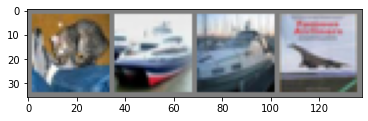

In [ ]:
#5. 테스트 집합을 이용하여 신경망 성능 확인
dataiter = iter(testloader)
images, labels = dataiter.next()

#print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth:', ''.join('%5s ' % classes[labels[j]] for j in range(4)))

## (5) 화면 출력 확인
- `net.eval()`을 사용한 학습한 모델에 대한 예측 값

In [ ]:
net.eval()
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted:', ''.join('%5s ' % classes[predicted[j]] for j in range(4)))

Predicted:   cat  ship   car plane 


## (6) 화면 출력 확인 및 일반화 성능 서술
- 테스트 데이터를 사용한 정확도 출력

In [ ]:
#performance on the whole test dataset
correct = 0
total= 0
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 51 %


## (7) 화면 출력 확인 및 부류별 분류기의 성능 서술
- 각 클래스별 정답률

In [ ]:
#performance on each class
class_correct = list(0. for i in range(10))
class_total = list(0.for i in range(10))
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

for i in range(10):
  print('Accuracy of %5s: %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 62 %
Accuracy of   car: 86 %
Accuracy of  bird: 30 %
Accuracy of   cat: 34 %
Accuracy of  deer: 34 %
Accuracy of   dog: 35 %
Accuracy of  frog: 61 %
Accuracy of horse: 57 %
Accuracy of  ship: 74 %
Accuracy of truck: 41 %


# 4 - (a) 10개 5*5필터들을 보폭 1과 덧대기 2로 적용하였 을 때 출력의 크기와 매개변수의 수를 구하세요 (3점)

In [ ]:
#입력 크기가 32*32*3이고 10개의 5*5 필터들을 보폭 1과 덧대기 2로
#적용하였을 때의 출력 크키와 매개변수의 수
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net1(nn.Module):
  def __init__(self):
    super(Net1, self).__init__()
    self.conv1 = nn.Conv2d(3, 10, 5, padding=2)
  def forward(self, x):
    x = self.conv1(x)
    return x
  
net = Net1()
print(net)
input = torch.randn(1, 3, 32, 32)
output = net(input)
print(output.size())

#전체 매개변수의  --> ((K * K * inp_ch) * out_ch) + out_ch
print("전체 매개변수의 개수는", ((5 * 5 * 3) * 10) + 10)

Net1(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)
torch.Size([1, 10, 32, 32])
전체 매개변수의 개수는 760


# 4 - (b) 동일한 입력에 64개 3*3필터들을 보폭 1과 덧대기 1로 적용하였을 때 출력의 크기와 매개변수의 수도 구하세요 (3점)

In [ ]:
#동일한 입력에 64개 3*3필터들을 보폭 1과 덧대기 1로 적용하였을때
#출력의 크기와 매개변수의 수
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net2(nn.Module):
  def __init__(self):
    super(Net2, self).__init__()
    self.conv1 = nn.Conv2d(3, 64, 3, 1, padding=1)
  def forward(self, x):
    x = self.conv1(x)
    return x

net = Net2()
print(net)
input = torch.randn(1, 3, 32, 32)
output = net(input)
print(output.size())

#전체 매개변수의 개수
print("전체 매개변수의 수는", (3*3*3)*64 + 64)

Net2(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
torch.Size([1, 64, 32, 32])
전체 매개변수의 수는 1792


# 5. 다음 조건을 만족하는 컨볼루션 신경망을 구현하고, 3 번의 (3), (6), (7)의 성능 결과를 확인하고 비교하세요. (60 점)

## (1) `INPUT-CONV(output_channel=32, kernel_size=3*3)-CONV(32,3*3)-RELU-POOL- CONV(32,3*3)-CONV(32, 3*3)-RELU-MAXPOOL-FC-OUTPUT` (10 점)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net3(nn.Module):
  def __init__(self):
    super(Net3, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(32 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
  
  def forward(self, x):
    x = self.pool(self.relu(self.conv2(self.conv1(x))))
    x = self.pool(self.relu(self.conv2(self.conv2(x))))
    x = torch.flatten(x,1)
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.fc3(x)
    return x

## (2) `INPUT-CONV(32,3*3,1)-ReLU-(module1)-MAXPOOL-(module1)-MAXPOOL- CONV(128,3*3,1)-ReLU-(module2)-(module2)-(module2)-GlobalAveragePooling- FC(128*class_number)-OUTPUT` (15점)

In [ ]:
def module1():
  temp = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=32,kernel_size=3,padding=1),
                       nn.BatchNorm2d(32),
                       nn.ReLU()
                       )
  return temp

def module2():
  temp = nn.Sequential(nn.Conv2d(128,128,kernel_size=3,padding=1),
                       nn.BatchNorm2d(128),
                       nn.ReLU()
                       )
  return temp

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.module1_1 = module1()
    self.module1_2 = module1()

    self.conv2 = nn.Conv2d(32,128,3,padding=1)
    self.module2_1 = module2()
    self.module2_2 = module2()
    self.module2_3 = module2()

    self.fc = nn.Linear(128, 10)
    
    self.pool = nn.MaxPool2d(2, 2)
    self.gap = nn.AdaptiveAvgPool2d((1, 1))    
    self.act = nn.ReLU()
    
  def forward(self, x):
    x = self.act(self.conv1(x))
    x = self.module1_1(x)
    x = self.pool(x)
    x = self.module1_2(x)
    x = self.pool(x)

    x = self.act(self.conv2(x))
    x = self.module2_1(x)
    x = self.module2_2(x)
    x = self.module2_3(x)
    
    x = self.gap(x)
    x = torch.flatten(x,1)
    x = self.fc(x)
    return x

## (3) 3번 문제의 신경망에 Adam 최적화 (강의자료의 기본 hyper-parameters 사용) 적용 (5점)
## (9) 3번 문제의 신경망에 L2놈 규제 적용 (5점)

In [ ]:
net = Net()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)

## (4) 데이터 확대 방법들 중 하나를 적용한 후, 3 번 문제의 신경망 학습 (Hint: transforms) (5 점)

In [ ]:
transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

## (5) 3 번 문제의 신경망에 CONV 층마다 배치 정규화를 적용 (Hint: nn.BatchNorm) (5 점)
## (6) 3 번 문제의 신경망 fc2 직후에 dropout(p=0.1) 적용 (5 점)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  #(4)배치 정규화 적용
  def __init__(self):
    super(Net, self).__init__()
    self.layer1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                          out_channels=32,
                                          kernel_size=5),
                                nn.BatchNorm2d(num_features=32),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer2 = nn.Sequential(nn.Conv2d(in_channels=32,
                                          out_channels=32,
                                          kernel_size=5),
                                nn.BatchNorm2d(num_features=32),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2, stride=2))
    
    self.fc1 = nn.Linear(32 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.dropout = nn.Dropout(p=0.1)

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = x.view(-1, 32 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = self.dropout(F.relu(self.fc2(x)))
    #softmax를 통해서 확률값을 먼저 도출
    x = F.softmax(self.fc3(x))
    return x

net = Net()
print(net)

Net(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=800, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [ ]:
input = torch.randn(1, 3, 32, 32)
output = net(input)
output

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[0.1192, 0.0923, 0.0955, 0.0819, 0.0954, 0.1234, 0.1037, 0.0917, 0.0998,
         0.0970]], grad_fn=<SoftmaxBackward>)

## (7) 3 번 문제의 신경망 fc layer 들에 Xavier initialization 적용 (Hint: nn.init.xavier_uniform_) (5 점)

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    
    for fc in [self.fc1, self.fc2, self.fc3]:
      nn.init.xavier_uniform_(fc.weight, .1)  # 이 부분만 있어도 정답 인정
      nn.init.constant_(fc.bias, 0.)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x
  
net = Net()

## (8) 3 번 문제의 신경망에 로그우도 (-log) 손실함수를 적용 (5 점)

In [ ]:
input = torch.randn(1, 3, 32, 32)
target = torch.tensor([1])
output = net(input)

criterion = nn.NLLLoss()
m = nn.LogSoftmax()
loss = criterion(m(output), target)
print(loss)

tensor(2.3030, grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


# 6. 신경망의 출력이 (0.4, 2.0, 0.001, 0.32)T일 때 소프트맥스 함수를 적용한 결과를 쓰시오. (6점)

In [ ]:
output = torch.tensor([[0.4, 2.0, 0.001, 0.32]])
F.softmax(output)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


tensor([[0.1325, 0.6563, 0.0889, 0.1223]])

# 7.  소프트맥스 함수를 적용한 후 출력이 (0.001,0.9,0.001,0.098)T이고 레이블 정보가 (0,0,0,1)T일 때, 세 가지 목적함수, 평균제곱 오차, 교차 엔트로피, 로그우도를 계산하시오. (6점)

In [ ]:
predicted = torch.tensor([[0.001, 0.9, 0.001, 0.098]])
label_mse = torch.tensor([0, 0, 0, 1])
label = torch.tensor([3])

print('shape of predicted', predicted.shape)
print('shape of label', label.shape)

criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()
criterion3 = nn.NLLLoss()

#MSELoss를 사용한 오차크기
loss1 = criterion1(predicted, label_mse)
print('MSE loss', loss1.item())

#CrossEntropyLoss를 사용한 오차크기
import math
loss2 = -1 * (math.log(0.098))
print('Cross entropy loss ', loss2)

#NLLLoss를 사용한 오차크기
loss3 = criterion3(torch.log(predicted), label)
print('NLL loss ', loss3.item())

shape of predicted torch.Size([1, 4])
shape of label torch.Size([1])
MSE loss 0.4059014916419983
Cross entropy loss  2.322787800311565
NLL loss  2.3227877616882324


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([1, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
